# Double Dueling Deep Q-Network with experience replay implementation



In [28]:
ABS_PATH = 'checkpoints/prioritized-dueling_dqn/'

In [29]:
import os
if not os.path.exists(ABS_PATH):
    os.mkdir(ABS_PATH)

In [30]:
import gym
import numpy as np
import pandas as pd
import tqdm
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(0,'../')
from buffers.frame_buffer import FrameBuffer
from preprocessings.atari_preprocessing import AtariPreprocess

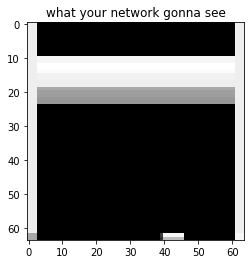

In [31]:
import gym
# spawn game instance for tests
env = gym.make("BreakoutDeterministic-v0")  # create raw env
env = AtariPreprocess(env)

observation_shape = env.observation_space.shape
n_actions = env.action_space.n

obs = env.reset()

plt.title("what your network gonna see")
plt.imshow(obs.reshape((64,64)), interpolation='none', cmap='gray')

### Frame buffer

In [32]:
def make_env():
    env = gym.make("BreakoutDeterministic-v0")
    env = BreakoutPreprocess(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env


env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

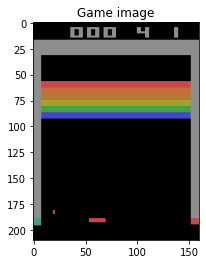

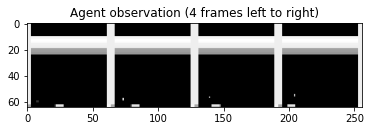

In [33]:
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0, 2, 1]).reshape([state_dim[0], -1]), cmap='gray')

### Building a network


### Majour settings

In [34]:
path_agent = ''
path_target = ''
initial_epsilon = 1
eta = 2.5e-4
alpha = 0.5
beta = 0.5
load = False
train = True

In [35]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()

/home/volodymyr/envs/dqn_env/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [36]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, Lambda, Subtract, Add
from tensorflow.keras.models import Model

In [37]:
class DDQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tf.variable_scope(name, reuse=reuse):
            x = Input(shape=state_shape)
            self.model = Conv2D(filters=16, kernel_size=(3,3), padding='valid', strides=(2,2), activation='relu')(x)
            self.model = Conv2D(filters=32, kernel_size=(3,3), padding='valid', strides=(2,2),activation='relu')(self.model)
            self.model = Conv2D(filters=64, kernel_size=(3,3), padding='valid', strides=(2,2),activation='relu')(self.model)
            self.model = Flatten()(self.model)
            self.model = Dense(256, activation='relu')(self.model)
            self.advantage_layer = Dense(n_actions)(self.model)
            self.advantage_mean_layer = Lambda(lambda x: tf.reduce_mean(x,axis=1))(self.advantage_layer)
            self.advantage_layer = Subtract()([self.advantage_layer,self.advantage_mean_layer])
            self.value_layer = Dense(1)(self.model)
            self.model = Add()([self.value_layer,self.advantage_layer])
            self.model = Model(inputs=x, outputs=self.model)

            self.state_t = tf.placeholder('float32', [None, ] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)

        self.weights = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon
        self.chosen_path = None
        
    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        qvalues = self.model(state_t)

        assert tf.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions

        return qvalues
    
    def save_weights(self,path):
        self.model.save_weights(path)
    
    def load_weights(self,path=None):
        if not path:
            files = os.listdir(ABS_PATH)
            assert files, "Can't load weights, as there is no saved weight in {0}".format('checkpoints/dqn/')
            path = sorted(files, key=lambda x: re.findall(r'step:\d+',x)[0].split(':')[1])[-1]
            path = os.path.join(ABS_PATH,path)   
            self.chosen_path = path
        self.model.load_weights(path)
        print('Loaded weights')
    
    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [38]:
agent = DDQNAgent("dqn_agent", state_dim, n_actions, epsilon=initial_epsilon)
sess.run(tf.global_variables_initializer())

Now let's try out our agent to see if it raises any errors.

In [39]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [40]:
evaluate(env, agent, n_games=1)

0.0

In [41]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    s = env.framebuffer
    rewards = 0
    last_info = None
    for i in range(n_steps):
      qvalues = agent.get_qvalues([s])
      a = agent.sample_actions(qvalues)[0]
      next_s, r, done, info = env.step(a)
      if (last_info is not None and last_info['ale.lives'] > info['ale.lives'] ):
        done = True
      exp_replay.add(s,a,r,next_s,done)
      s = next_s
      last_info = info
      rewards += r
      if done:
        s = env.reset()
    return rewards

In [42]:
target_network = DDQNAgent("target_network", state_dim, n_actions)

In [43]:
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    return assigns

In [44]:
copy_step = load_weigths_into_target_network(agent,target_network)

### Learning with... Q-learning


In [45]:
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])
sample_weights_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

In [46]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
actions_with_max = tf.argmax(current_qvalues, axis=1)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)


In [47]:
next_qvalues_target = target_network.get_symbolic_qvalues(next_obs_ph) 
next_state_values_target = tf.reduce_sum(tf.one_hot(actions_with_max,n_actions)*next_qvalues_target,axis=1)
# next_state_values_target = tf.reduce_max(next_qvalues_target, axis=1)  
reference_qvalues = rewards_ph+gamma*next_state_values_target*is_not_done 

td_error = tf.math.abs(current_action_qvalues - reference_qvalues)
td_loss = sample_weights_ph*(td_error**2)
td_loss = tf.reduce_mean(td_loss)

train_step = tf.train.AdamOptimizer(eta).minimize(td_loss, var_list=agent.weights)

In [48]:
sess.run(tf.global_variables_initializer())

In [49]:
if load:
    path_agent = path_agent if path_agent else None
    agent.load_weights(path_agent)
    
if load:
    path_target = path_target if path_agent else None
    target_network.load_weights(path_target)

### Main loop


In [50]:
epochs = 20
buffer_size = 30000
annealing = 0.998
batch_size = 64

In [51]:
from tqdm import trange
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt
import datetime
from buffers.replay_buffer import PrioritizedReplayBuffer
%matplotlib inline

def moving_average(x, span=100, **kw):
    return pd.DataFrame({'x': np.asarray(x)}).x.ewm(span=span, **kw).mean().values

mean_rw_history = []
td_loss_history = []

buffer size = 30000, epsilon = 0.10000, epoch = 19


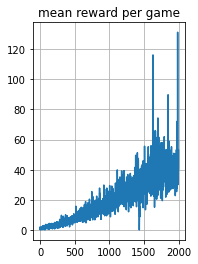

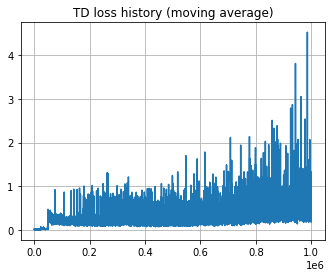

100%|██████████| 1000000/1000000 [13:50:11<00:00, 20.08it/s]


In [52]:
if train:
    date_stamp = datetime.datetime.strftime(datetime.datetime.now(), format='%Y-%m-%d')
    exp_replay = PrioritizedReplayBuffer(buffer_size, alpha=alpha,beta=beta)
    play_and_record(agent, env, exp_replay, n_steps=10000)


    def sample_batch(exp_replay, batch_size):
        obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch, sample_weights_batch, indexes_batch = exp_replay.sample(batch_size)
        return ({
            obs_ph: obs_batch,
            actions_ph: act_batch,
            rewards_ph: reward_batch,
            next_obs_ph: next_obs_batch,
            is_done_ph: is_done_batch,
            sample_weights_ph: sample_weights_batch
        },
    indexes_batch)
    
    continue_train = False
    if agent.chosen_path:
        continue_train = True
        step = int(re.findall(r'_step:\d+',agent.chosen_path)[0].split(':')[1])

    for i in trange(epochs*50000):
        # play
        play_and_record(agent, env, exp_replay, 10)

        # train
        to_feed, indexes = sample_batch(exp_replay, batch_size=batch_size)
        _, loss_t, td_error_t = sess.run([train_step, td_loss, td_error], to_feed)
        td_loss_history.append(loss_t)
        exp_replay.update_priorities(td_error_t,indexes)

        # adjust agent parameters
        if i % 500 == 0:
            sess.run(copy_step)
            agent.epsilon = max(agent.epsilon * annealing, 0.1)
            mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
        if len(exp_replay)==buffer_size and i!=0 and i%50000==0:
            exp_replay.update_parameters()
            print(f'Alpha : {exp_replay.alpha}')
            print(f'Beta : {exp_replay.beta}')
        if i%(10*50000)==0:
            if continue_train:
                step+=i
            else:
                step = i
            agent.model.save_weights(os.path.join(ABS_PATH,f'agent_model_weights_step:{step}_date:{date_stamp}.h5'))
            target_network.model.save_weights(os.path.join(ABS_PATH,f'target_model_weights_step:{step}_date:{date_stamp}.h5'))

        if i % 100 == 0:
            clear_output(True)
            print("buffer size = %i, epsilon = %.5f, epoch = %i" % (len(exp_replay), agent.epsilon,i//50000))

            plt.subplot(1, 2, 1)
            plt.title("mean reward per game")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(loss_t)
            plt.figure(figsize=[12, 4])
            plt.subplot(1, 2, 2)
            plt.title("TD loss history (moving average)")
            plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
            plt.grid()
            plt.show()
            
    agent.model.save_weights(os.path.join(ABS_PATH,f'agent_model_weights_step:{step}_date:{date_stamp}.h5'))
    target_network.model.save_weights(os.path.join(ABS_PATH,f'target_model_weights_step:{step}_date:{date_stamp}.h5'))


Text(0, 0.5, 'reward')

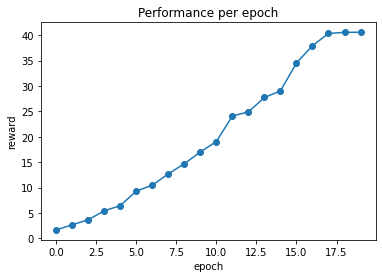

In [53]:
result = [np.mean(mean_rw_history[i:i+100]) for i in range(0,len(mean_rw_history),100)]
plt.plot(result,'o-')
plt.title('Performance per epoch')
plt.xlabel('epoch')
plt.ylabel('reward')

# Visualization of playing

In [3]:
agent.epsilon = 0.003

NameError: name 'agent' is not defined

In [55]:
from IPython.core import display

In [56]:

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Step: %d %s" % (step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

Sum of rewards : 37.0


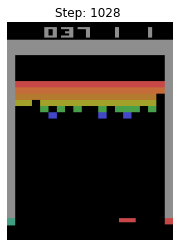

In [58]:
env = make_env()
steps = 10000
s = env.reset()
rewards = 0
last_info = None
for t in range(steps):
    show_state(env,t)
    env.render()
    qvalues = agent.get_qvalues([s])
    a = agent.sample_actions(qvalues)[0]
    next_s, r, done, info = env.step(a)
    if (last_info is not None and last_info['ale.lives'] > info['ale.lives'] ):
        done = True
    rewards+=r
    s = next_s
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()
display.clear_output(wait=True)
print("Sum of rewards : {}".format(rewards))